In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [2]:
data_dir = 'D:\Cityscapes'
image_folder = os.path.join(data_dir, 'D:\Cityscapes\leftImg8bit_trainvaltest/train')
annotation_folder = os.path.join(data_dir, 'D:\Cityscapes\gtFine_trainvaltest/train')

Loaded images and masks shapes: (174, 1024, 2048, 3) (174, 1024, 2048, 3)


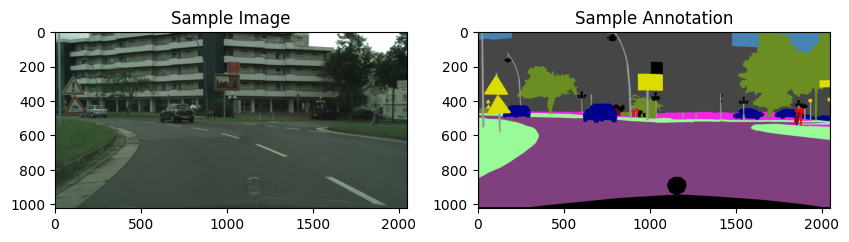

In [3]:
def load_images_and_masks(city='aachen'):
    images = []
    masks = []
    city_image_path = os.path.join(image_folder, city)
    city_annotation_path = os.path.join(annotation_folder, city)
    image_files = sorted([os.path.join(city_image_path, f) for f in os.listdir(city_image_path) if f.endswith('_leftImg8bit.png')])
    mask_files = sorted([os.path.join(city_annotation_path, f) for f in os.listdir(city_annotation_path) if f.endswith('_gtFine_color.png')])

    for img_path, mask_path in zip(image_files, mask_files):
        img = img_to_array(load_img(img_path))
        mask = img_to_array(load_img(mask_path))
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Load a sample of images and masks
sample_images, sample_masks = load_images_and_masks()
print("Loaded images and masks shapes:", sample_images.shape, sample_masks.shape)

# Display the first image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_images[0].astype('uint8'))
plt.title('Sample Image')
plt.subplot(1, 2, 2)
plt.imshow(sample_masks[0].astype('uint8'))
plt.title('Sample Annotation')
plt.show()

In [4]:
def unet(input_shape=(256, 256, 3), num_classes=3):
    inputs = Input(input_shape)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c5)

    # Expansive Path
    u6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c6)

    u7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c7)

    u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c8)

    u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create and compile the refined model
model = unet()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 34,517,315 (131.67 MB)

 Trainable params: 34,515,395 (131.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [5]:
def preprocess_data(images, masks, target_size=(256, 256)):
    images_resized = np.array([tf.image.resize(img, target_size).numpy() for img in images])
    masks_resized = np.array([tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy() for mask in masks])
    images_normalized = images_resized / 255.0
    masks_converted = np.argmax(masks_resized, axis=-1)
    
    # Ensure masks have 4 dimensions
    masks_converted = np.expand_dims(masks_converted, axis=-1)
    
    return images_normalized, masks_converted

# Data Generator
def image_mask_generator(images, masks, batch_size):
    # Ensure masks have 4 dimensions
    if len(masks.shape) == 3:
        masks = np.expand_dims(masks, axis=-1)
    image_gen = image_datagen.flow(images, batch_size=batch_size, seed=1)
    mask_gen = mask_datagen.flow(masks, batch_size=batch_size, seed=1)
    while True:
        yield next(image_gen), next(mask_gen)

# Preprocess and split data
images_preprocessed, masks_preprocessed = preprocess_data(sample_images, sample_masks)
train_images, val_images, train_masks, val_masks = train_test_split(images_preprocessed, masks_preprocessed, test_size=0.2, random_state=42)

# Data Generator
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

Epoch 1/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.7548 - loss: 0.9803 - val_accuracy: 0.7694 - val_loss: 1.1010 - learning_rate: 0.0010
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7930 - loss: 0.8594 - val_accuracy: 0.7585 - val_loss: 1.1199 - learning_rate: 0.0010
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.8216 - loss: 0.7601 - val_accuracy: 0.7982 - val_loss: 1.4629 - learning_rate: 0.0010
Epoch 4/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.8272 - loss: 0.7232 - val_accuracy: 0.7759 - val_loss: 1.0698 - learning_rate: 0.0010
Epoch 5/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8252 - loss: 0.7315 - val_accuracy: 0.7621 - val_loss: 1.8738 - learning_rate: 0.0010
Epoch 6/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8144 - loss: 0.7038 - val_accuracy: 0.7742 - val_loss: 1.6654 - learning_rate: 0.0010
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.8485 - loss: 0.6275 - val_accuracy: 

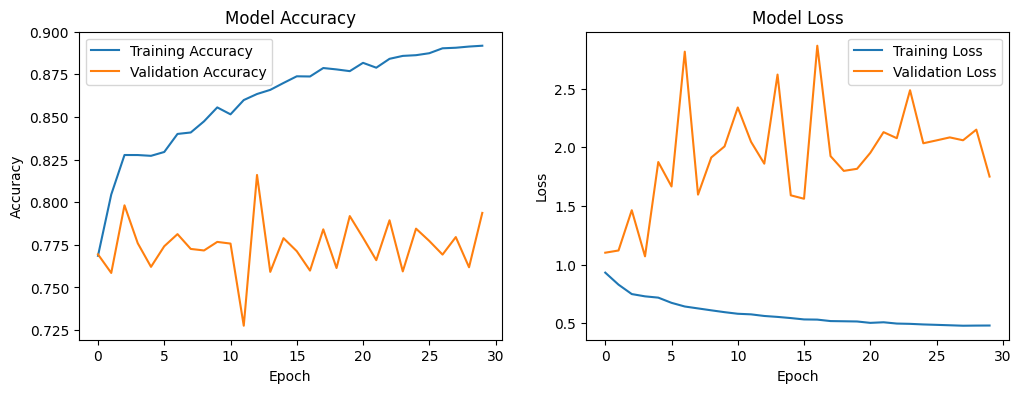

In [7]:
batch_size = 8
epochs = 30

train_gen = image_mask_generator(train_images, train_masks, batch_size)
val_gen = image_mask_generator(val_images, val_masks, batch_size)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images) // batch_size,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(val_images) // batch_size,
    callbacks=[reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
model.save('cityscapes_segmentation_model.keras')

# Save the model in TensorFlow's SavedModel format
model.export('cityscapes_segmentation_model')
import tensorflow as tf

# Load the saved model
saved_model_dir = 'cityscapes_segmentation_model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
tflite_model_path = 'cityscapes_segmentation_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

    import tensorflow as tf

# Load the saved model
saved_model_dir = 'cityscapes_segmentation_model'
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# Convert the model to TensorFlow Lite format
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a .tflite file
tflite_model_path = 'cityscapes_segmentation_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model successfully converted and saved at {tflite_model_path}")

INFO:tensorflow:Assets written to: cityscapes_segmentation_model\assets


INFO:tensorflow:Assets written to: cityscapes_segmentation_model\assets


Saved artifact at 'cityscapes_segmentation_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)
Captures:
  2018681349648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784556512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784555808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784556864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784556336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784555456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784556688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784558096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784557920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2020784558624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20207845584

In [9]:
model = tf.keras.models.load_model('cityscapes_segmentation_model.keras')

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 103,548,107 (395.00 MB)

 Trainable params: 34,515,395 (131.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 69,030,792 (263.33 MB)

In [10]:
test_images, test_masks = load_images_and_masks(city='aachen')

test_images_preprocessed, test_masks_preprocessed = preprocess_data(test_images, test_masks)

test_gen = image_mask_generator(test_images_preprocessed, test_masks_preprocessed, batch_size)

test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_images_preprocessed) // batch_size)
print(f"Test Accuracy: {test_accuracy:.2%}, Test Loss: {test_loss}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 953ms/step - accuracy: 0.7560 - loss: 2.0551
Test Accuracy: 75.02%, Test Loss: 2.1195285320281982


Loaded test images and masks shapes: (46, 1024, 2048, 3) (46, 1024, 2048, 3)


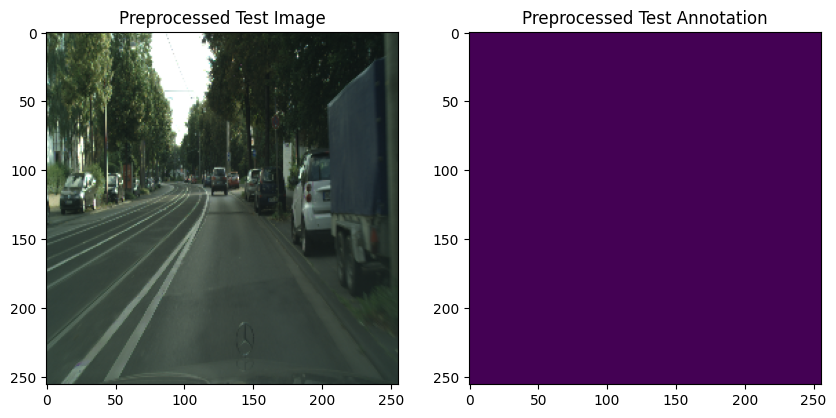

In [11]:
test_image_folder = os.path.join(data_dir, 'leftImg8bit_trainvaltest/test')
test_annotation_folder = os.path.join(data_dir, 'gtFine_trainvaltest/test')

def load_test_images_and_masks(city='bonn'):
    images = []
    masks = []
    city_image_path = os.path.join(test_image_folder, city)
    city_annotation_path = os.path.join(test_annotation_folder, city)
    image_files = sorted([os.path.join(city_image_path, f) for f in os.listdir(city_image_path) if f.endswith('_leftImg8bit.png')])
    mask_files = sorted([os.path.join(city_annotation_path, f) for f in os.listdir(city_annotation_path) if f.endswith('_gtFine_color.png')])

    for img_path, mask_path in zip(image_files, mask_files):
        img = img_to_array(load_img(img_path))
        mask = img_to_array(load_img(mask_path))
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

test_sample_images, test_sample_masks = load_test_images_and_masks()
print("Loaded test images and masks shapes:", test_sample_images.shape, test_sample_masks.shape)

test_images_preprocessed, test_masks_preprocessed = preprocess_data(test_sample_images, test_sample_masks)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_images_preprocessed[0])
plt.title('Preprocessed Test Image')
plt.subplot(1, 2, 2)
plt.imshow(test_masks_preprocessed[0])
plt.title('Preprocessed Test Annotation')
plt.show()

In [12]:
test_gen = image_mask_generator(test_images_preprocessed, test_masks_preprocessed, batch_size)

test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_images_preprocessed) // batch_size)
print(f"Test Accuracy: {test_accuracy:.2%}, Test Loss: {test_loss}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 834ms/step - accuracy: 1.0000 - loss: 0.2410
Test Accuracy: 100.00%, Test Loss: 0.2410489022731781
